# QBIO 401 - Assignment #9

In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from Bio import SeqIO

## Problem 1 - Creating 1mers and 1mers + Shapes

In [148]:
#####Used R function from Assignment 7 to create csv files for each shape parameter for each tf


#library(DNAshapeR)
#library(Biostrings)

#unboundCTCF <- getShape("ctcf_unbound.fasta")
#boundCTCF <- getShape("ctcf_bound.fasta")
#boundMAX <- getShape("max_bound.fasta")
#unboundMAX <- getShape("max_bound.fasta")

#createCSV <- function(data, name){
    #write.csv(data$MGW, paste0(name, "_MGW_.csv"), row.names = FALSE)
    #write.csv(data$ProT, paste0(name, "_ProT_.csv"), row.names = FALSE)
    #write.csv(data$Roll, paste0(name, "_Roll_.csv"), row.names = FALSE)
    #write.csv(data$HelT, paste0(name, "_HelT_.csv"), row.names = FALSE)
    #write.csv(data$EP, paste0(name, "_EP_.csv"), row.names = FALSE)
#}

#createCSV(unboundCTCF, "ctcf_unbounded")
#createCSV(boundCTCF, "ctcf_bounded")
#createCSV(unboundMAX, "max_unbounded")
#createCSV(boundMAX, "max_bounded")

In [149]:
def read_files(files):
    num_rows = 0
    num_cols = 0
    for file in files:
        file_data = pd.read_csv(file)
        num_cols += file_data.shape[1]
    num_rows = file_data.shape[0]
    data = np.empty((num_rows, num_cols))
    
    start_col = 0
    for file in files:
        file_data = pd.read_csv(file)
        end_col = start_col + file_data.shape[1]
        data[:, start_col:end_col] = file_data.values
        start_col = end_col
    
    return data

In [150]:
files1 = ['ctcf_bounded_EP_.csv', 'ctcf_bounded_HelT_.csv', 'ctcf_bounded_Roll_.csv', 'ctcf_bounded_MGW_.csv', 'ctcf_bounded_ProT_.csv']
ctcf_bounded_shapes = read_files(files1)
ctcf_bounded_shapes = np.nan_to_num(ctcf_bounded_shapes, nan=0)

files2 = ['ctcf_unbounded_EP_.csv', 'ctcf_unbounded_HelT_.csv', 'ctcf_unbounded_Roll_.csv', 'ctcf_unbounded_MGW_.csv', 'ctcf_unbounded_ProT_.csv']
ctcf_unbounded_shapes = read_files(files2)
ctcf_unbounded_shapes = np.nan_to_num(ctcf_unbounded_shapes, nan=0)

files3 = ['max_bounded_EP_.csv', 'max_bounded_HelT_.csv', 'max_bounded_Roll_.csv', 'max_bounded_MGW_.csv', 'max_bounded_ProT_.csv']
max_bounded_shapes = read_files(files3)
max_bounded_shapes = np.nan_to_num(max_bounded_shapes, nan=0)

files4 = ['max_unbounded_EP_.csv', 'max_unbounded_HelT_.csv', 'max_unbounded_Roll_.csv', 'max_unbounded_MGW_.csv', 'max_unbounded_ProT_.csv']
max_unbounded_shapes = read_files(files4)
max_unbounded_shapes = np.nan_to_num(max_unbounded_shapes, nan=0)

In [151]:
def normalize(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    non_zero = (max_vals - min_vals) != 0
    normalized = np.zeros_like(data, dtype=float)
    normalized[:, non_zero] = (data[:, non_zero] - min_vals[non_zero]) / (max_vals[non_zero] - min_vals[non_zero])
    return normalized

In [152]:
ctcf_bounded_shapes_n = normalize(ctcf_bounded_shapes)
ctcf_unbounded_shapes_n = normalize(ctcf_unbounded_shapes)
max_bounded_shapes_n = normalize(max_bounded_shapes)
max_unbounded_shapes_n = normalize(max_unbounded_shapes)

In [153]:
def encode_seq(seq):
    alphabet = {"A": "1000", "C" : "0100", "G" : "0010", "T" : "0001"}
    seq_encode = ''
    for letter in seq:
        seq_encode += alphabet[letter];
    return [int(item) for item in list(seq_encode)]

In [154]:
def create_1mer(filename, shape):
    seqs = open(filename, 'r').readlines()
    sequences = []
    for i in range(0, 4000):
        if(i%2==1):
            seq = seqs[i]
            sequences.append(seq[:-1])
    X_1mer = np.array([encode_seq(seq) for seq in sequences])
    X_1mer_shapes = np.hstack(((X_1mer, shape)))
    return X_1mer, X_1mer_shapes

In [155]:
ctcf_b_1mer, ctcf_b_1mer_shape = create_1mer('ctcf_bound.fasta', ctcf_bounded_shapes_n)
ctcf_ub_1mer, ctcf_ub_1mer_shape = create_1mer('ctcf_unbound.fasta', ctcf_unbounded_shapes_n)
max_b_1mer, max_b_1mer_shape = create_1mer('max_bound.fasta', max_bounded_shapes_n)
max_ub_1mer, max_ub_1mer_shape = create_1mer('max_unbound.fasta', max_unbounded_shapes_n)

In [156]:
def create_table(b, ub):
    df1 = pd.DataFrame({
        'sequence': [seq for seq in b],
        'label': 1
    })
    df2 = pd.DataFrame({
        'sequence': [seq for seq in ub],
        'label': 0
    })
    
    return pd.concat([df1, df2], ignore_index=True)

In [157]:
ctcf_1mr = create_table(ctcf_b_1mer, ctcf_ub_1mer)
ctcf_1mr_shape = create_table(ctcf_b_1mer_shape, ctcf_ub_1mer_shape)
max_1mr = create_table(max_b_1mer, max_ub_1mer)
max_1mr_shape = create_table(max_b_1mer_shape, max_ub_1mer_shape)

## Problem 2 - Finding Best C Values for Each tf

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [159]:
logistic_model = LogisticRegression()
def grid_search(X, y, param):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    
    best_C = grid_search.best_params_['C']
    best_score = grid_search.best_score_
    
    y_pred = grid_search.predict_proba(X_test)[:, 1]  # Probability of positive class
    auc_score = roc_auc_score(y_test, y_pred)
    
    return best_C, best_score, auc_score

In [160]:
param = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
tfs = [ctcf_1mr, ctcf_1mr_shape, max_1mr, max_1mr_shape]
names = ["ctcf_1mr", "ctcf_1mr_shape", "max_1mr", "max_1mr_shape"]
best_scores = []
for tf , name in zip(tfs, names):
    best_C_1mer, best_score_1mer, auc_score_1mer = grid_search(tf['sequence'].tolist(), tf['label'], param)
    best_scores.append(best_C_1mer)
    print("Best C for ", name, ": ", best_C_1mer, "Best AUROC:", auc_score_1mer)

Best C for  ctcf_1mr :  0.01 Best AUROC: 0.9563930890945109
Best C for  ctcf_1mr_shape :  100 Best AUROC: 0.999993731036385
Best C for  max_1mr :  0.01 Best AUROC: 0.9352416058577196
Best C for  max_1mr_shape :  100 Best AUROC: 1.0


## Problem 3 - Comparing Performance Using ROC

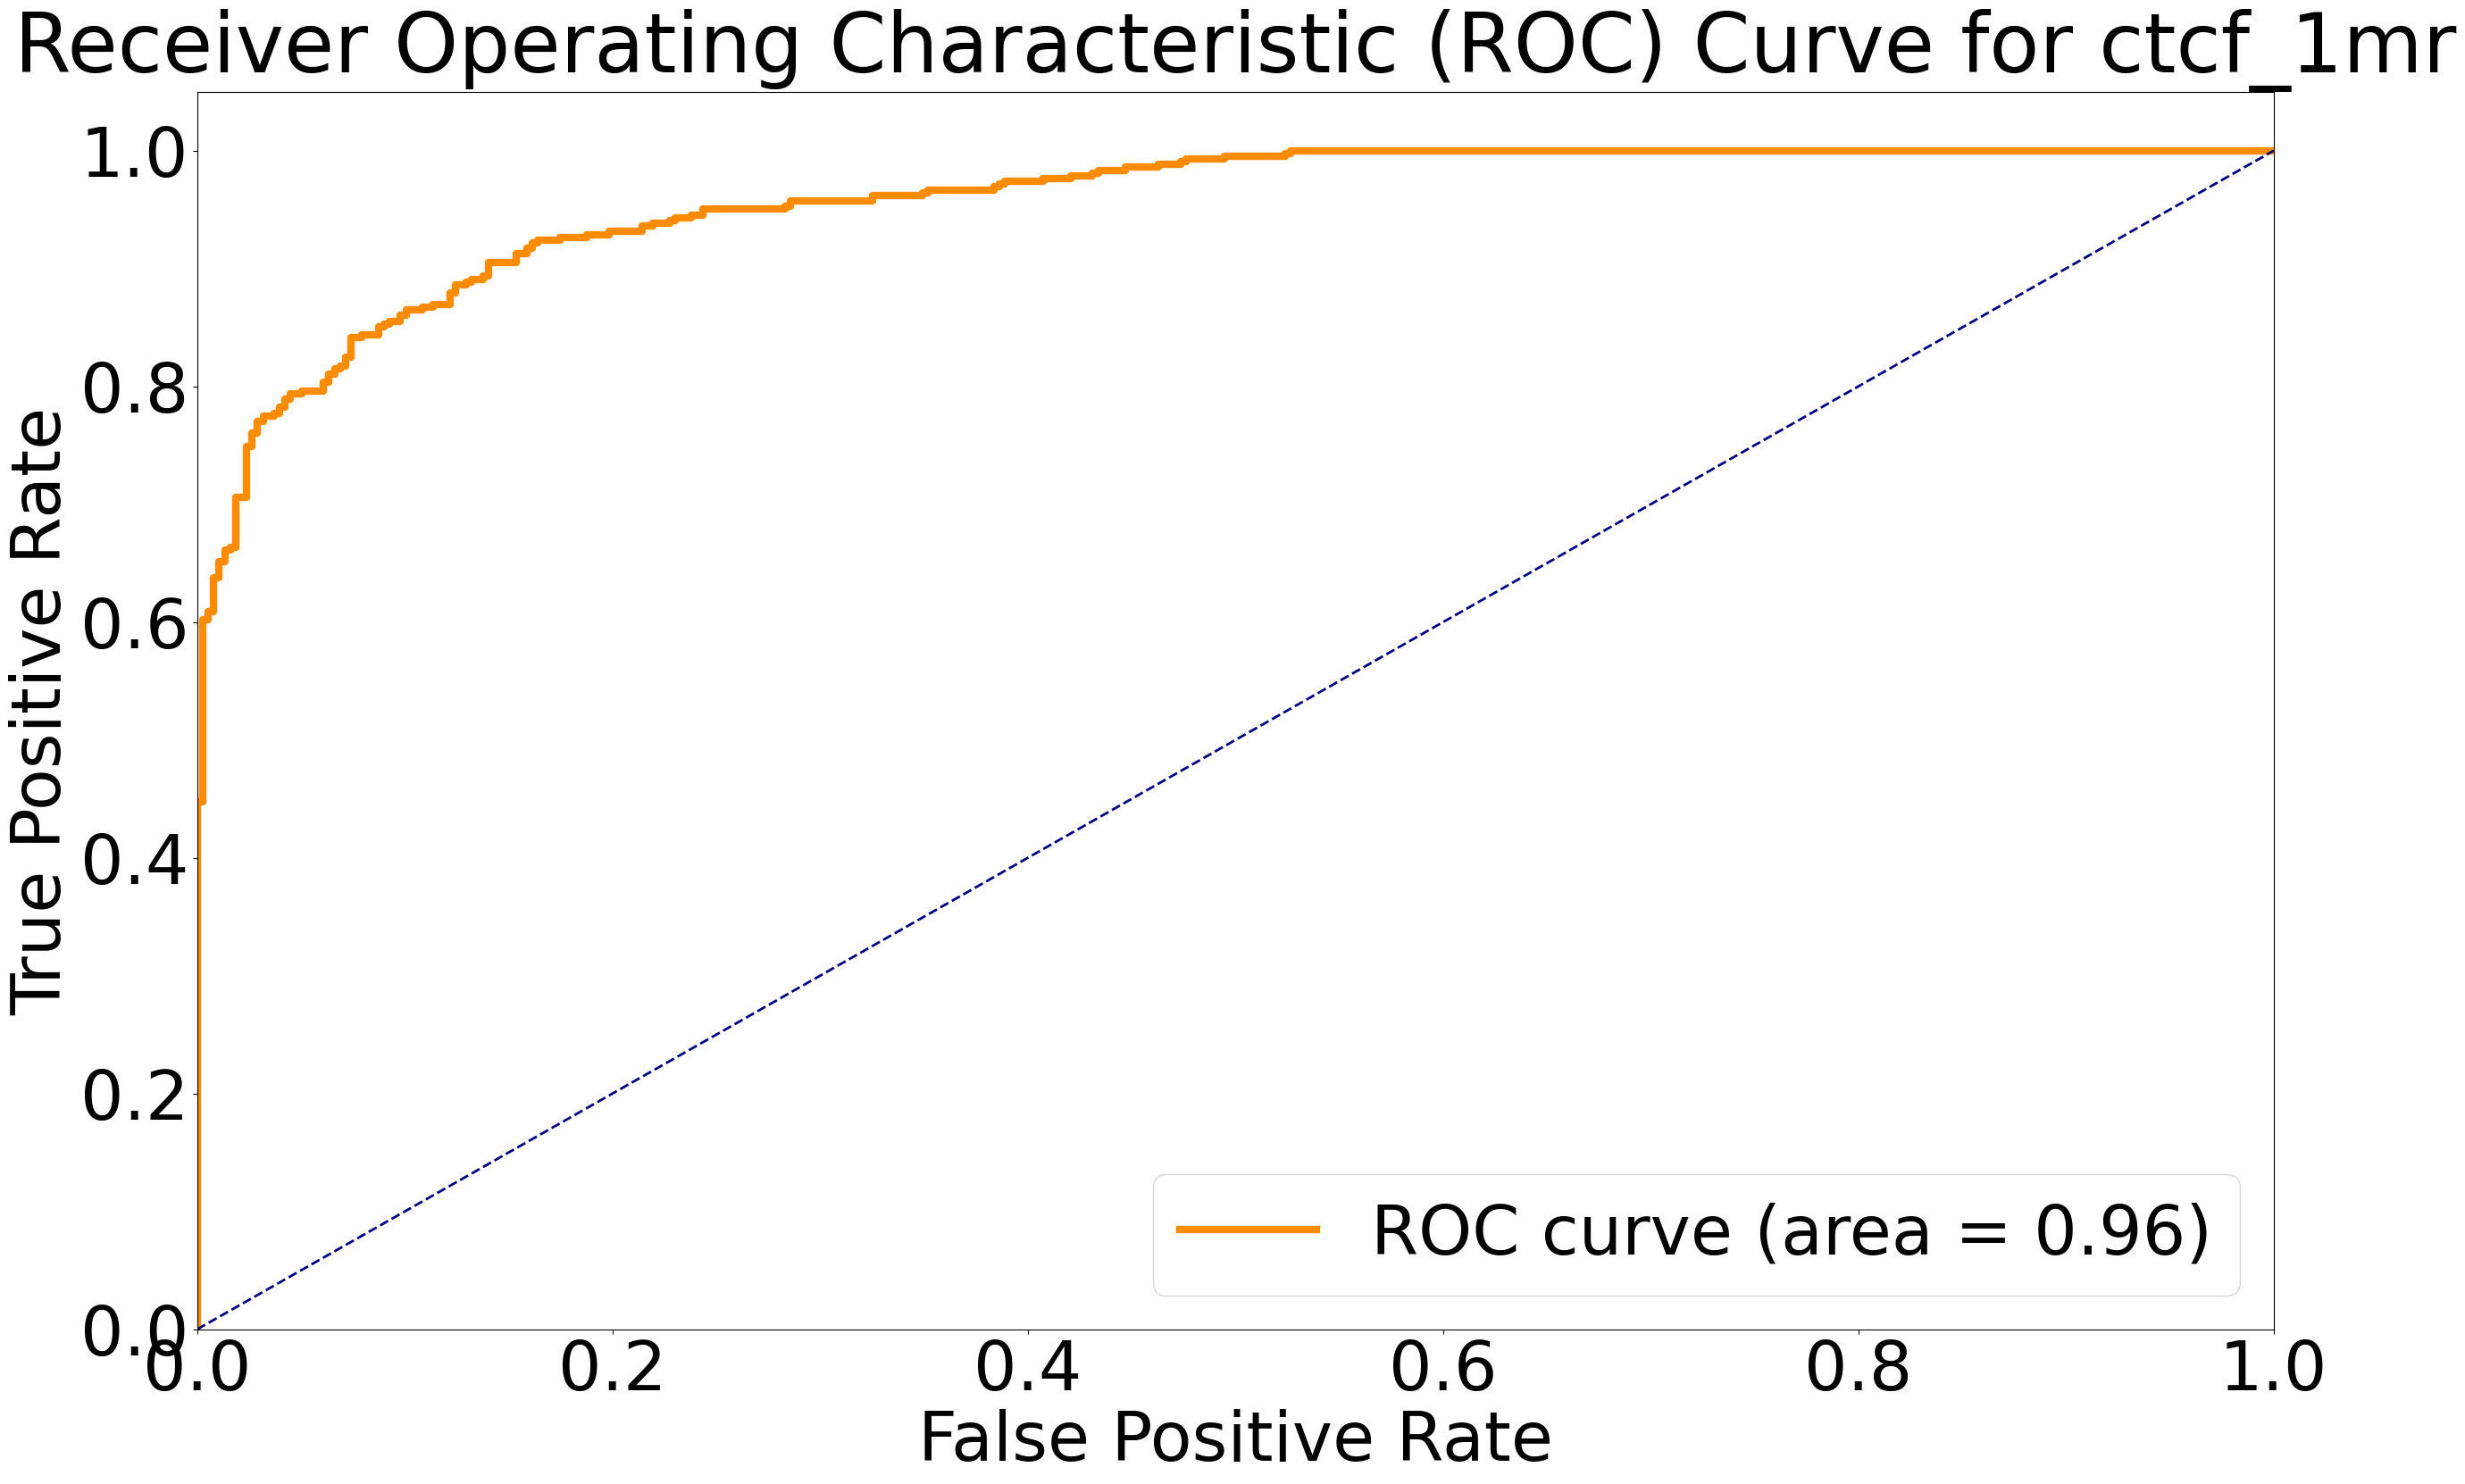

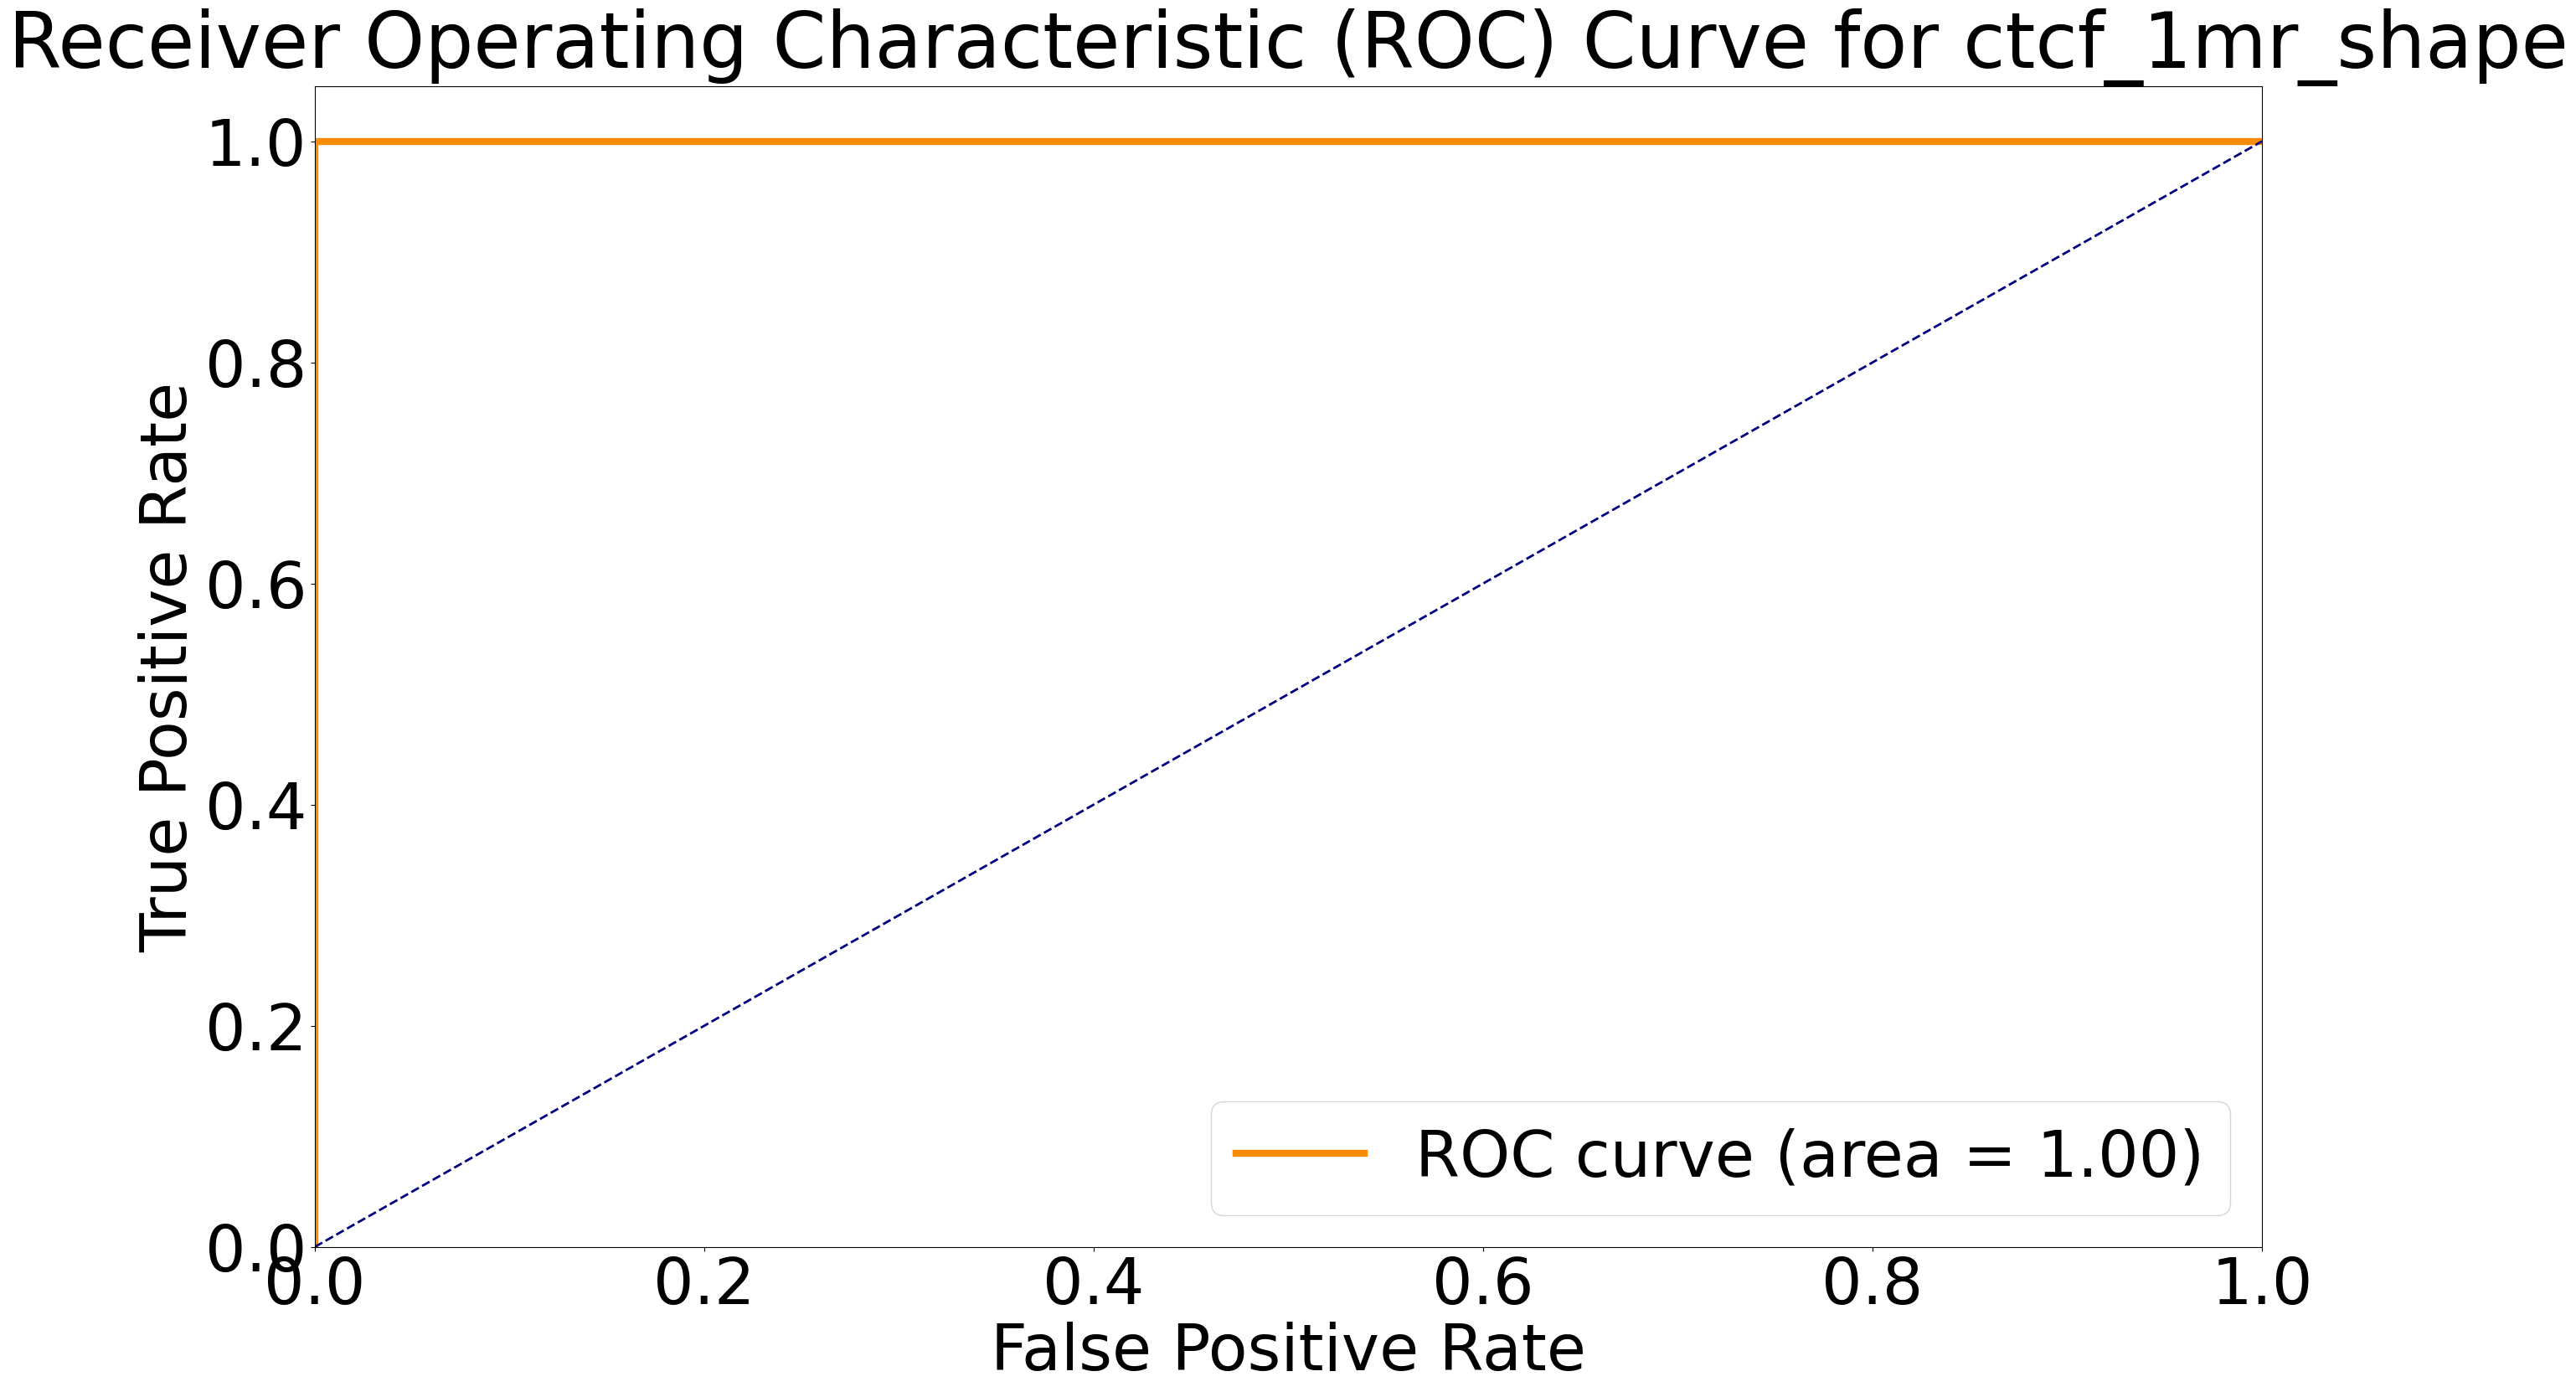

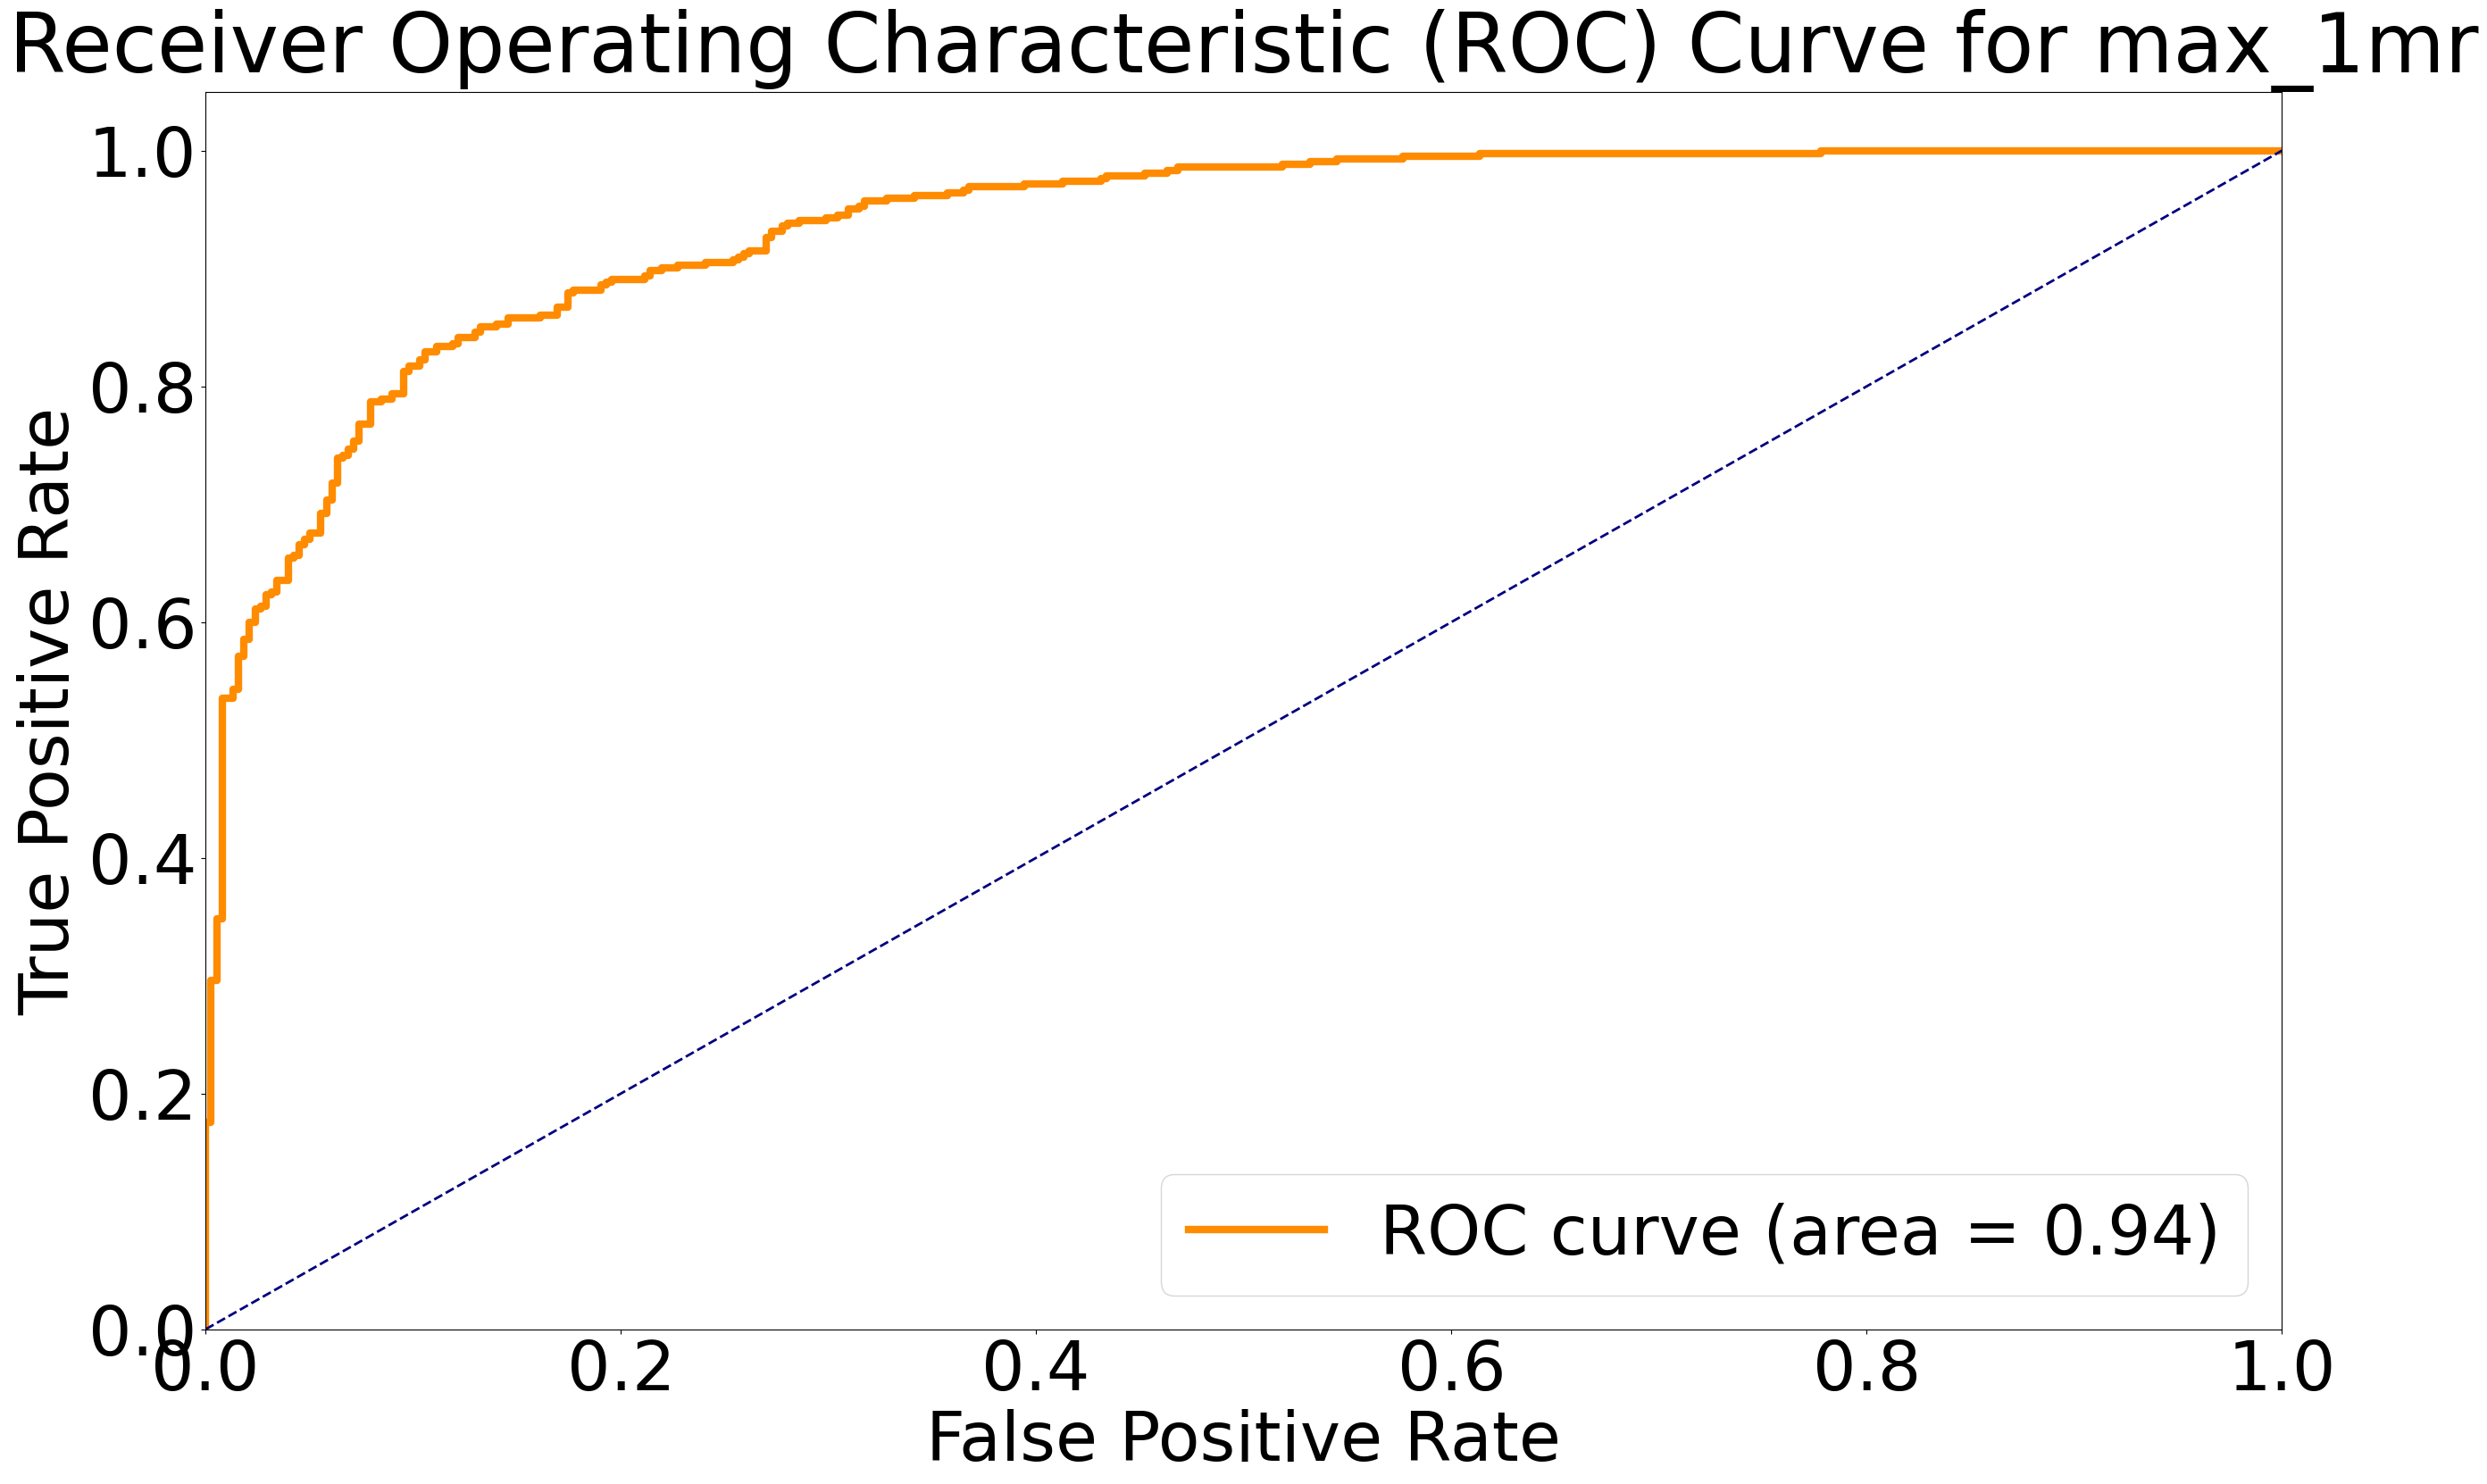

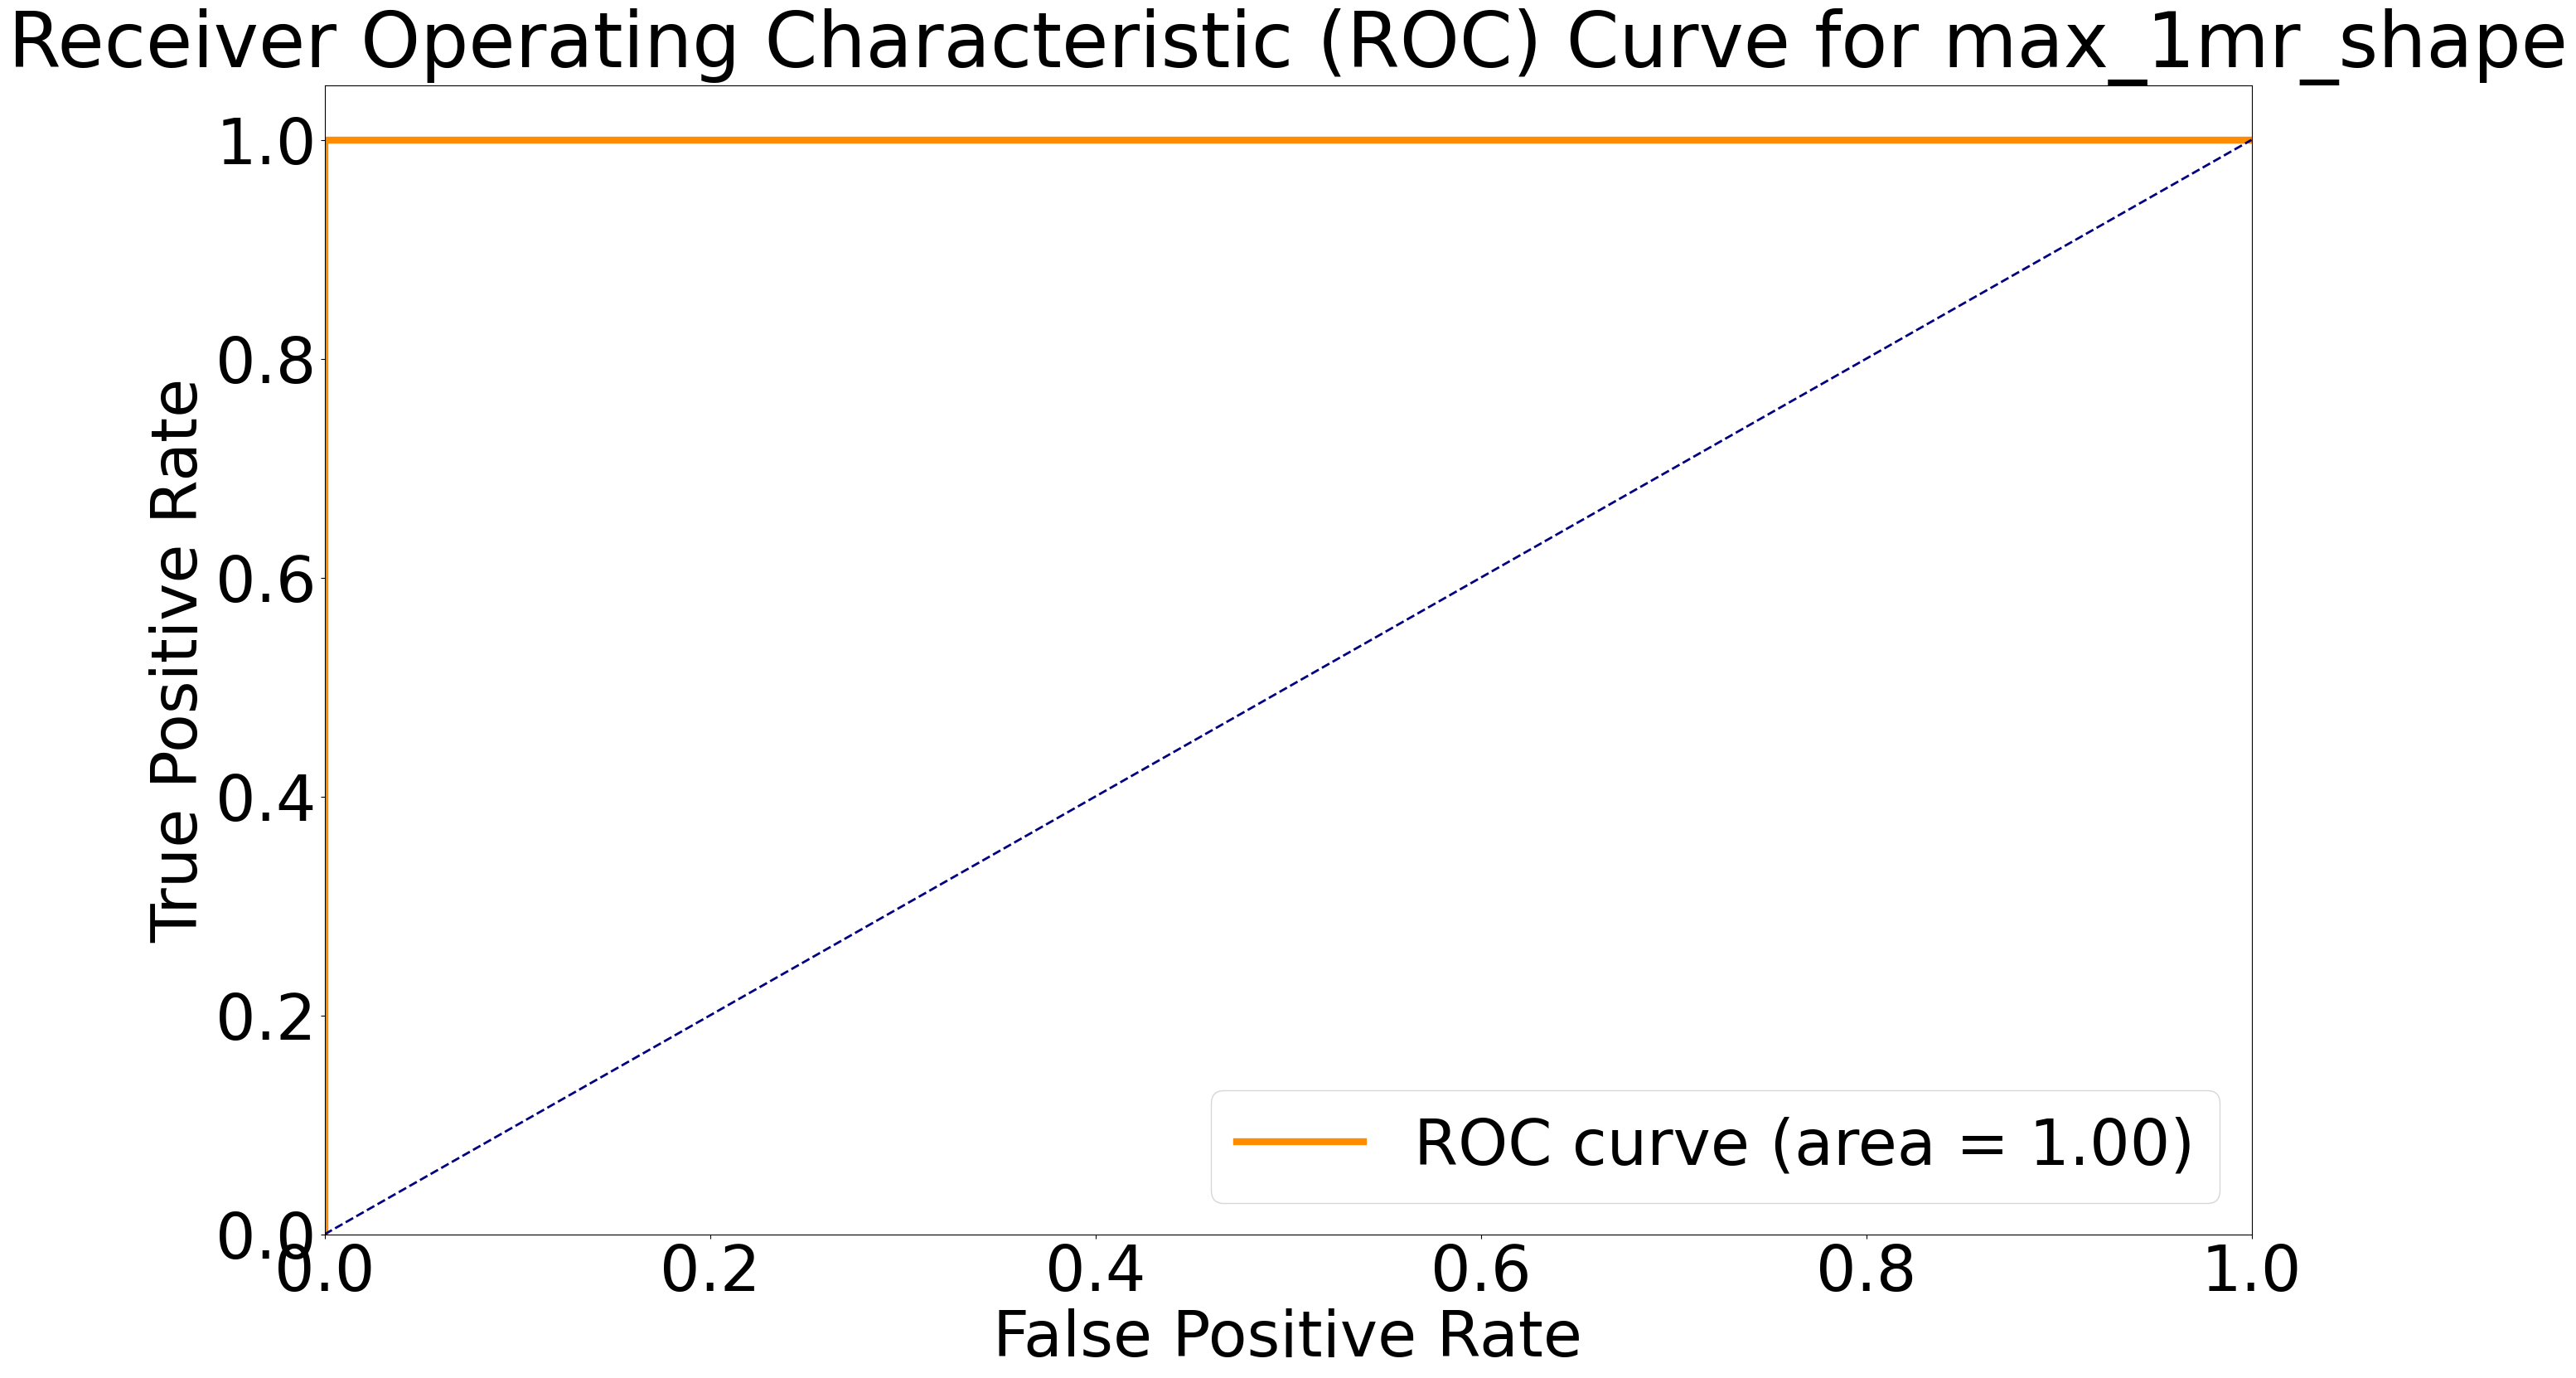

In [161]:
for tf , name , c in zip(tfs, names, best_scores):
    log_reg = LogisticRegression(max_iter=1000, random_state=0, C=c)
    X_train, X_test, y_train, y_test = train_test_split(tf['sequence'].tolist(), tf['label'], test_size=0.2, random_state=42)
    log_reg.fit(X_train, y_train)

    y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auroc = roc_auc_score(y_test, y_pred_proba)

    fontsize = 55
    plt.rcParams.update({'font.size': fontsize})
    plt.figure(figsize=(30, 18))
    plt.plot(fpr, tpr, color='darkorange', lw=6, label=f'ROC curve (area = {auroc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

It is clear from the plots that when the shape features are added to the model, the model is much more accurate in classifying whether the sequence binds or not. This is clear from the ROC values of one for the both TFs with the shape features vs the smaller ROC values of 0.96 and 0.94 for CTCF and MAX respectively. 